<Body>   
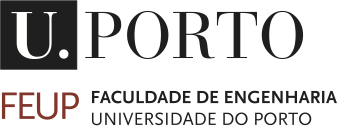   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using cGAN

In [725]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import torch.autograd as autograd

## Data preprocessing

In [726]:
df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [727]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


In [728]:
class FraudDataset(Dataset):
 
  def __init__(self, dataframe, fraud = True):
    scaler = StandardScaler()
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]
 
    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    #y = np.reshape(y, (1,-1))
    
    # Standardize data
    #x = scaler.fit_transform(x)
    #y = scaler.fit_transform(y)

    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)
   
  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [729]:
train_dataloader = DataLoader(creditData, batch_size=64, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=64, drop_last=True)

## Conditional Generative Adversarial Network

### Architecture

In [730]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, nr_features)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [731]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
         nn.Linear(nr_features, 2048),
        nn.ReLU(),
        nn.Linear(2048, 1024),
        nn.ReLU(inplace = True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
        
        nn.Linear(512, 256),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
        
        nn.Linear(256, 128),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
        
        nn.Linear(128, 64),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
        
        nn.Linear(64, 32),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
        
        nn.Linear(32, 16),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
        
        nn.Linear(16, 1),
        nn.Sigmoid()
        )
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [732]:
#define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

latent_dim = 7
nr_features = 30

#create optimizer for the generator
generator = Generator(latent_dim, nr_features).to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

#create optimizer for the descriminator
discriminator = Discriminator(nr_features)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

print(f"Using {device} device")


Using cpu device


In [733]:
print('\t\t\tGenerator')
summary(generator, input_size=(latent_dim,))

			Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             128
              ReLU-2                   [-1, 16]               0
            Linear-3                   [-1, 32]             544
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 30]             990
Total params: 1,662
Trainable params: 1,662
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [734]:
print('\t\t\tDiscriminator')
summary(discriminator, input_size=(nr_features,))

			Discriminator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]          63,488
              ReLU-2                 [-1, 2048]               0
            Linear-3                 [-1, 1024]       2,098,176
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
              ReLU-6                  [-1, 512]               0
         Dropout2d-7                  [-1, 512]               0
            Linear-8                  [-1, 256]         131,328
              ReLU-9                  [-1, 256]               0
        Dropout2d-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
             ReLU-12                  [-1, 128]               0
        Dropout2d-13                  [-1, 128]               0
           Linear-14  

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


####  Loss Function + Device + Reset Gradients Funct.

In [735]:
def train_generator(opt_g, cur_batch_size, criterion):
    # Clear generator gradients
    opt_g.zero_grad()
    
   
    fake_targets = torch.ones((cur_batch_size),  device = device)
    
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    g_loss = criterion(fake_preds, fake_targets)


    g_loss.backward()
    opt_g.step()
    
    return g_loss, generated_data

In [736]:
criterion = nn.BCELoss()

In [737]:
def train_discriminator(real_data, real_labels,  opt_d, cur_batch_size):
    # Reset gradients
    opt_d.zero_grad()
    
   
    #real_labels = df_fraud['Class'].to_numpy() #sendo que estamos 
    
    real_labels = torch.ones((cur_batch_size), device=device) * 0.9 * (1 - real_labels)
    
    real_preds = discriminator(real_data).reshape(-1)
    d_loss_real = criterion(real_preds, real_labels)
    
    fake_labels = torch.zeros((cur_batch_size),  device = device) *0.1

    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)

    #z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (real_data.shape[0], latent_dim))).to(device))
    generated_data = generator(latent_space_samples).detach()  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    d_loss_fake = criterion(fake_preds, fake_labels)
    #d_loss_fake = criterion(fake_preds, fake_labels)
    
    loss = d_loss_real + d_loss_fake

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
    
        
    return loss

In [738]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.0001
        self.batch_size = 64
        self.n_critic = 5
        self.clip_value = 0.01
        
        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(device)
        self.D = Discriminator(nr_features=self.dataset.features).to(device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.lr)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.lr)

    

    def train(self,real_data, cur_batch_size, epochs=1000):
        losses_gen = []
        losses_dis = []
        for epoch in range(epochs):  
            for i, (real_data, real_labels)  in enumerate(self.dataloader):
                cur_batch_size = real_data.shape[0] #check this
                # Train discriminator
                d_error = train_discriminator(real_data, real_labels, self.d_optimizer, cur_batch_size)
                #g_error = train_generator(generator_optimizer, cur_batch_size, criterion)
                #print(f'Discriminator loss {dis_loss:.3f}')

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)
                
                

                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    g_error, _ = train_generator(self.g_optimizer, cur_batch_size, criterion)
                
                
               
                losses_gen.append(g_error)
                losses_dis.append(d_error)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch, epoch, i+1, len(self.dataloader), d_error.item(), g_error.item()))
            
        return losses_gen, losses_dis



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(device)
            gen = self.G(z)
            return gen.cpu().numpy()

In [739]:
gan = GAN(df_train)

In [740]:
losses_gen, losses_dis = gan.train(df_train, 64, epochs=400)

Epoch [0/0], Step [7/7], d_loss: 1.8980, g_loss: 0.4532 

Epoch [1/1], Step [7/7], d_loss: 1.8217, g_loss: 0.4529 

Epoch [2/2], Step [7/7], d_loss: 1.7820, g_loss: 0.4524 

Epoch [3/3], Step [7/7], d_loss: 1.9489, g_loss: 0.4526 

Epoch [4/4], Step [7/7], d_loss: 1.8063, g_loss: 0.4529 

Epoch [5/5], Step [7/7], d_loss: 1.8890, g_loss: 0.4532 

Epoch [6/6], Step [7/7], d_loss: 1.7913, g_loss: 0.4533 

Epoch [7/7], Step [7/7], d_loss: 1.8214, g_loss: 0.4533 

Epoch [8/8], Step [7/7], d_loss: 1.7532, g_loss: 0.4534 

Epoch [9/9], Step [7/7], d_loss: 1.8128, g_loss: 0.4532 

Epoch [10/10], Step [7/7], d_loss: 1.8334, g_loss: 0.4530 

Epoch [11/11], Step [7/7], d_loss: 1.8480, g_loss: 0.4528 

Epoch [12/12], Step [7/7], d_loss: 1.9464, g_loss: 0.4533 

Epoch [13/13], Step [7/7], d_loss: 1.8061, g_loss: 0.4531 

Epoch [14/14], Step [7/7], d_loss: 1.8497, g_loss: 0.4529 

Epoch [15/15], Step [7/7], d_loss: 1.8753, g_loss: 0.4525 

Epoch [16/16], Step [7/7], d_loss: 1.8069, g_loss: 0.4526 



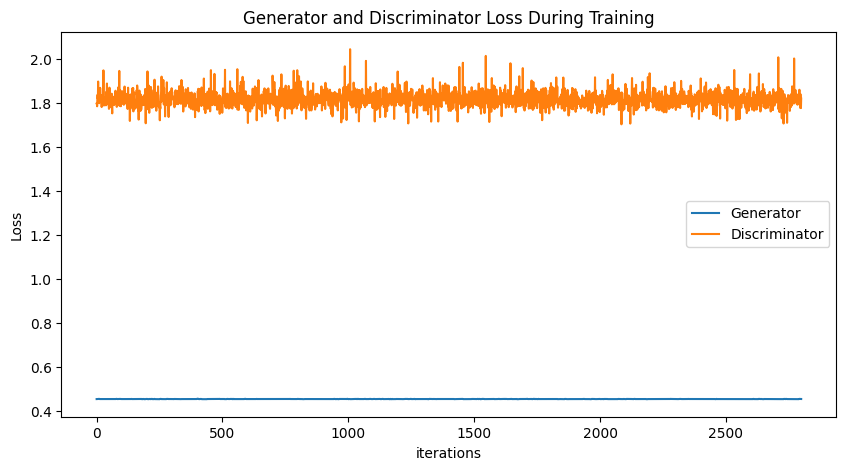

In [741]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.detach().numpy() for i in losses_gen]
    losses_dis = [i.detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations") #Epochs * Steps
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

In [742]:
sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
gan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, gan_df], ignore_index=True)

In [743]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
223361,143352.0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
165061,117173.0,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0
238186,149565.0,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,11.99,0
150562,93670.0,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,117.44,0
138452,82655.0,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,25.76,0


In [744]:
gan_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.277002,-0.146063,0.233019,-0.043695,-0.017901,0.109405,-0.007605,-0.409824,0.046263,0.000194,...,-0.123350,0.013073,0.038749,0.226321,0.094540,0.060790,0.161562,0.089951,-0.114782,1.0
1,0.326531,-0.228940,0.039083,-0.168260,0.145743,0.032571,0.005569,-0.187388,0.052348,0.015186,...,0.042457,-0.018422,0.277655,0.245617,-0.112555,0.004485,0.103506,0.180459,-0.001151,1.0
2,0.224919,-0.127052,0.111945,-0.147701,0.011434,-0.000102,-0.153616,-0.249347,0.023963,-0.022105,...,-0.015389,0.036513,0.268039,0.224530,-0.096327,0.052622,0.215651,0.166359,0.031498,1.0
3,0.282254,-0.121417,0.159133,-0.143105,-0.031897,0.030414,-0.151391,-0.336546,-0.009077,-0.000783,...,-0.079888,0.084316,0.224917,0.260360,-0.098270,0.026865,0.194473,0.193045,-0.003479,1.0
4,0.223742,-0.172303,0.142851,-0.157765,0.092459,0.061798,-0.064576,-0.327476,0.054262,-0.043270,...,-0.088686,-0.043432,0.146082,0.246100,-0.051274,0.052695,0.175434,0.072614,-0.067452,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227446,0.224688,-0.157675,0.083365,-0.162460,0.087777,-0.015342,-0.015472,-0.272663,-0.099504,0.102006,...,0.073480,-0.039476,0.253377,0.321939,0.101610,-0.021547,0.083347,0.170578,0.165761,1.0
227447,0.415752,-0.211313,-0.027428,-0.200721,-0.057810,0.183858,-0.082009,-0.198103,-0.063947,0.000355,...,0.000714,0.004280,0.327753,0.240160,-0.007228,-0.005164,0.125155,0.111551,-0.048524,1.0
227448,0.208251,-0.096009,0.080211,-0.110286,-0.027447,0.158490,-0.072507,-0.398565,0.025537,-0.030852,...,-0.101621,-0.007415,0.144267,0.312016,0.031436,0.002495,0.124709,0.076061,-0.098753,1.0
227449,0.234853,-0.152546,0.117210,-0.135121,0.121647,0.035392,-0.040003,-0.277666,-0.039186,0.025964,...,0.052362,-0.046516,0.179504,0.235919,-0.092945,0.012112,0.130997,0.134621,0.024560,1.0


In [745]:
df_concat['Class'].value_counts()

Class
1.0    227845
0.0    227451
Name: count, dtype: int64

### Model evaluation

In [746]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [747]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
        preds = self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1
        ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        print(classification_report(test_df['Class'].values, labels))

In [748]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=100)
fw_model.evaluate(df_test, confidence=0.90)

[Epoch 0/100] loss: 5.485362


KeyboardInterrupt: 